In [2]:
!pip install pydub
!pip install audiomentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.io import wavfile
import os.path
import IPython.display
import seaborn as sns
import librosa
import librosa.display
import soundfile
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Flatten, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers

from keras import optimizers,regularizers
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.decomposition import PCA
from tensorflow.keras.regularizers import l2
import warnings

In [4]:
import re
import os
import wave
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydub import AudioSegment
from IPython.display import Audio, display
import librosa as lib
import librosa.display

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
PATH = "/content/drive/MyDrive/Colab Notebooks/Crema"
AUDIO_PATH = "/content/drive/MyDrive/Colab Notebooks/Crema/1001_DFA_ANG_XX.wav"

In [6]:
def zeroCrossingRate(audio):
  return lib.feature.zero_crossing_rate(audio)

In [7]:
def energy(audio):
  # using a spectrogram will give a more accurate representation
  # of energy over time because its frames can be windowed
  S, phase = lib.magphase(lib.stft(audio))
  return lib.feature.rms(S=S).mean()

In [8]:
def chromaStft(audio, sr):
  stft = np.abs(librosa.stft(audio))
  return librosa.feature.chroma_stft(S=stft, sr=sr, n_fft=200).mean()

In [9]:
def mfcc(data, sr):
  return librosa.feature.mfcc(y=data, sr=sr, n_fft=200).mean()

In [10]:
def melSpectrogram(audio, sr):
  mel_spectrogram = lib.feature.melspectrogram(y=audio, sr=sr, n_fft=200, n_mels=64)
  log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
  return log_mel_spectrogram

In [11]:
def playAudio(audio_file):
  audio = AudioSegment.from_wav(audio_file)
  # Play the audio
  audio.export('temp_audio.wav', format='wav')
  audio_data = open('temp_audio.wav', 'rb').read()
  display(Audio(audio_data))
  # Delete the temporary audio file
  os.remove('temp_audio.wav')

In [12]:
def visualize_waveform(audio, sr):
    plt.figure(figsize=(12, 4))
    plt.plot(audio)
    plt.xlabel('Time')
    plt.ylabel('Amplitude')
    plt.title('Waveform')
    plt.show()

In [13]:
def splitData(dataset_path):
  audio_files = glob.glob(os.path.join(dataset_path, "*.wav"))
  audio_train, audio_test = train_test_split(audio_files, test_size=0.3, random_state=42, shuffle=True)
  return audio_train, audio_test

In [14]:
D_train, D_test = splitData(PATH)

In [15]:
print(len(D_train), len(D_test))

5216 2236


In [16]:
D_test[0]

'/content/drive/MyDrive/Colab Notebooks/Crema/1017_WSI_FEA_XX.wav'

In [17]:
def getMaxLen(audio_files):
  max_length = 0
  for audio_file in audio_files:
    audio, _ = librosa.load(audio_file)
    length = len(audio)
    max_length = max(max_length, length)
  return max_length

In [18]:
def showClasses(PATH):
    classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"] 
    for cls in classes:
        print(cls)
        audio_files = glob.glob(os.path.join(PATH, f"*{cls}*.wav"))
        playAudio(audio_files[0])
        audio, sr = lib.load(audio_files[0])
        visualize_waveform(audio, sr)

In [19]:
def loadAudioTime(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  showClasses(PATH)
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract zero crossing rate
    zcr = zeroCrossingRate(audio)
    # extract energy
    rms = energy(audio)
    # chroma stft
    cs = chromaStft(audio, sr)
    # mfcc
    mfc = mfcc(audio, sr)
    # extract mel spectrogram
    #mel_spec = melSpectrogram(audio, sr).mean()
    combined_features = np.concatenate(([rms, cs, mfc], (np.pad(zcr[0], (0, 300 - len(zcr[0]))))))
    D.append(combined_features)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
  
  return D, Y

In [20]:
def loadAudioFreq(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  showClasses(PATH)
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract mel spectrogram
    mel_spec = melSpectrogram(audio, sr)
    D.append(mel_spec)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    
  return D, Y

## Time Domain Model Without Augmentation

SAD


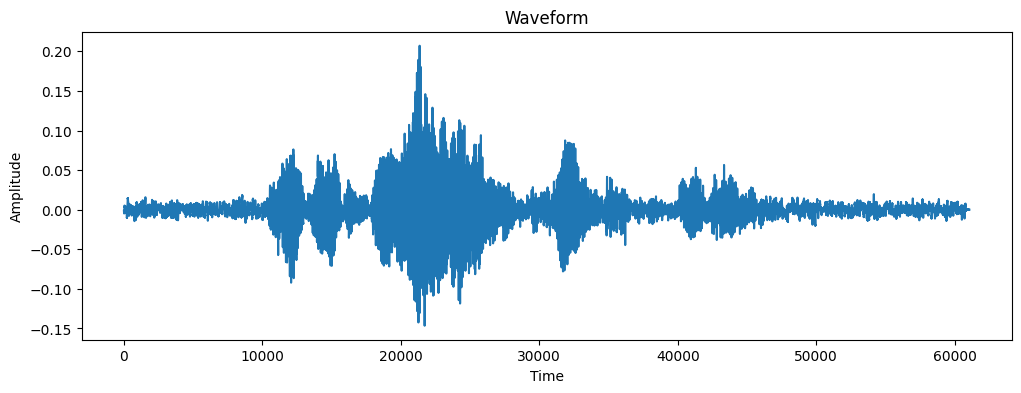

ANG


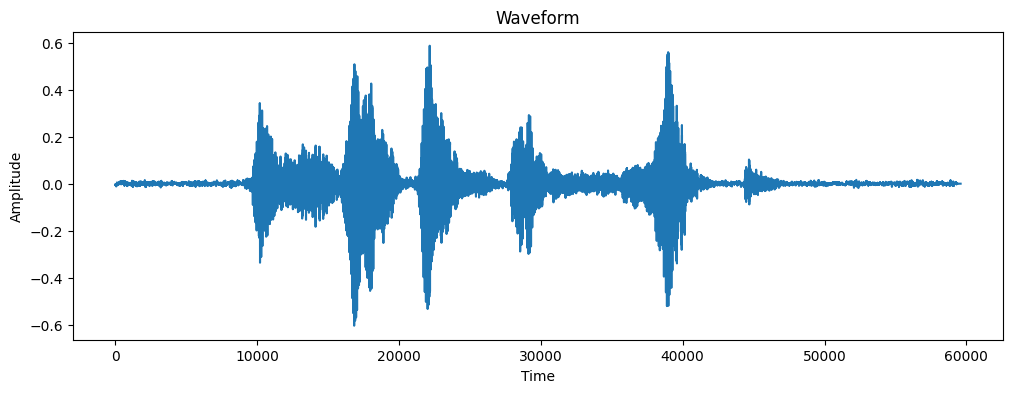

DIS


FEA


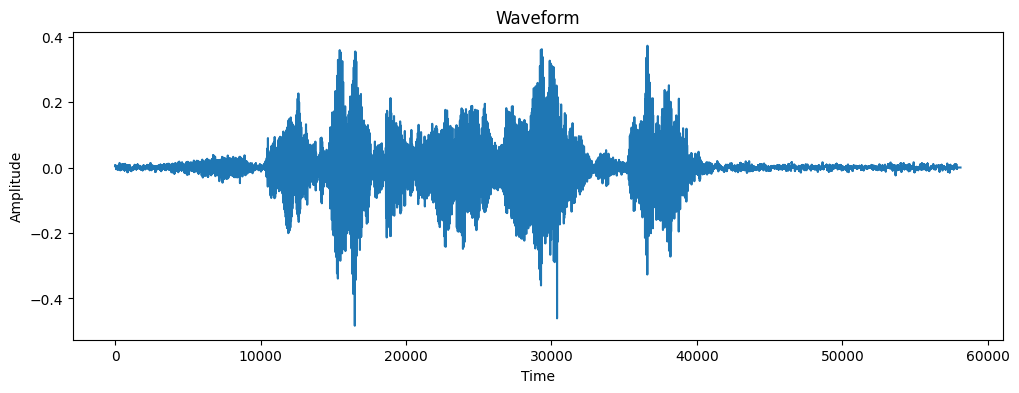

HAP


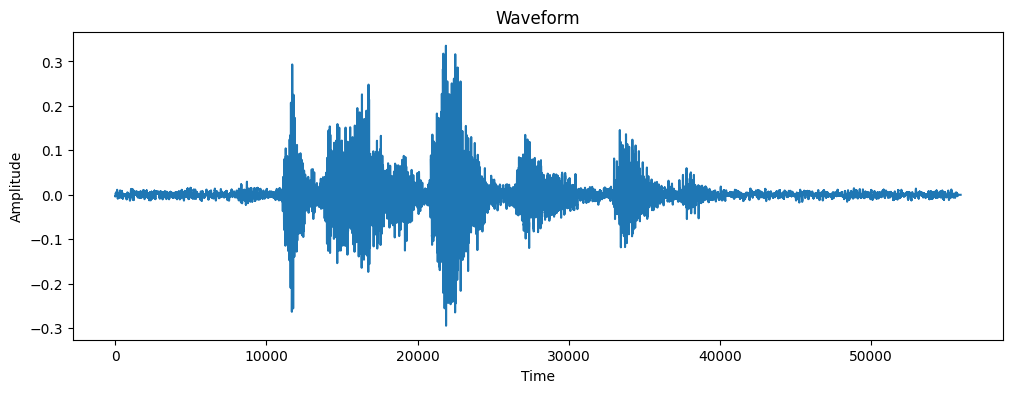

NEU


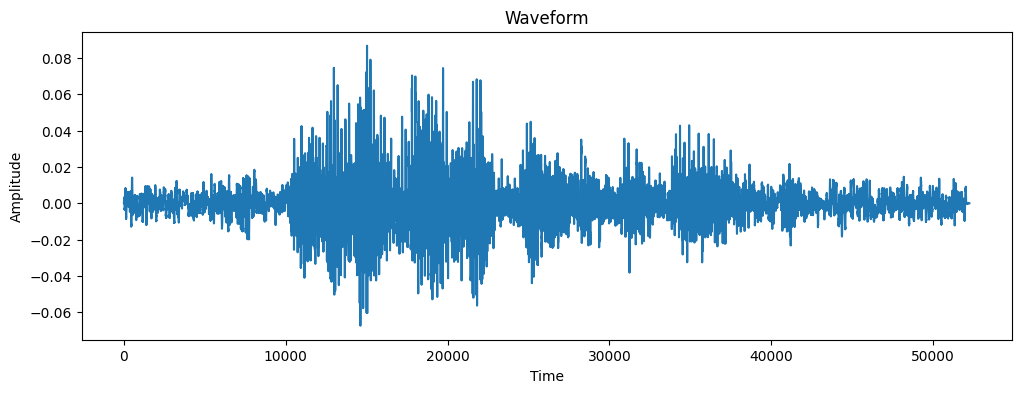

/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [209]:
D_time, Y_time = loadAudioTime(D_train)

In [210]:
D_time = np.array(D_time)
D_time.shape

(5216, 303)

In [211]:
unicheck = np.unique(Y_time, axis=0)
print(f"Check on time domain:\n{unicheck}")

Check on time domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [212]:
df_time = pd.DataFrame(Y_time)
df_time.head()

0
0  FEA
1  FEA
2  HAP
3  HAP
4  ANG

In [213]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_time)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(5216, 6)


In [214]:
Y_time = one_hot_labels
Y_time.shape

(5216, 6)

In [215]:
# Apply PCA to the data
pca = PCA(n_components=200)
D_pca = pca.fit_transform(D_time)

In [216]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(np.array(D_pca), np.array(Y_time), test_size=0.05, random_state=69, shuffle=True, stratify=Y_time)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(Conv1D(128, 3, input_shape=(x_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(512, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(1024, 3,  kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

model.summary()

# Train the model with early stopping
history = model.fit(x_train, y_train,
                    validation_data=(x_train, y_train),
                    epochs=50,
                    batch_size=32,
                    callbacks=callbacks)

((4955, 200), (4955, 6), (261, 200), (261, 6))
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_16 (Conv1D)          (None, 198, 128)          512       
                                                                 
 batch_normalization_28 (Bat  (None, 198, 128)         512       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 198, 128)          0         
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 99, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 97, 256)           98560     
                                                                 
 batch

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
155/155 [==============================] - 5s 21ms/step - loss: 3.5432 - accuracy: 0.3102 - val_loss: 3.8696 - val_accuracy: 0.1427
Epoch 2/50
155/155 [==============================] - 3s 18ms/step - loss: 2.9400 - accuracy: 0.3465 - val_loss: 3.6523 - val_accuracy: 0.1429
Epoch 3/50
155/155 [==============================] - 3s 22ms/step - loss: 2.6843 - accuracy: 0.3576 - val_loss: 3.1712 - val_accuracy: 0.1925
Epoch 4/50
155/155 [==============================] - 3s 22ms/step - loss: 2.4994 - accuracy: 0.3774 - val_loss: 2.7161 - val_accuracy: 0.2597
Epoch 5/50
155/155 [==============================] - 3s 18ms/step - loss: 2.3852 - accuracy: 0.3768 - val_loss: 2.3016 - val_accuracy: 0.3952
Epoch 6/50
155/155 [==============================] - 3s 18ms/step - loss: 2.2923 - accuracy: 0.3907 - val_loss: 2.2041 - val_accuracy: 0.4119
Epoch 7/50
155/155 [==============================] - 3s 18ms/step - loss: 2.2190 - accuracy: 0.3943 - val_loss: 2.1599 - val_accuracy: 0.4032

SAD


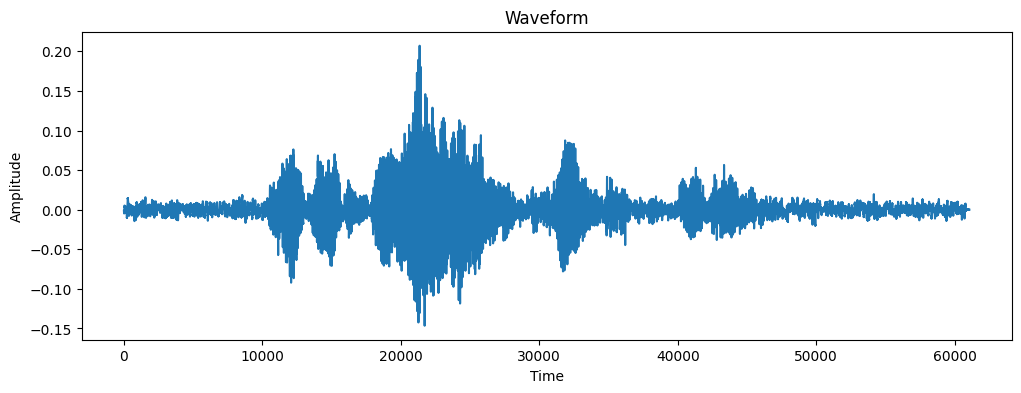

ANG


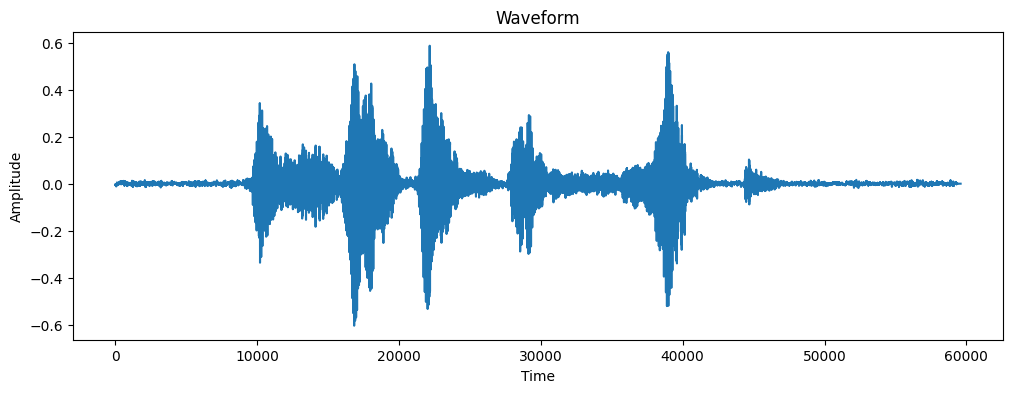

DIS


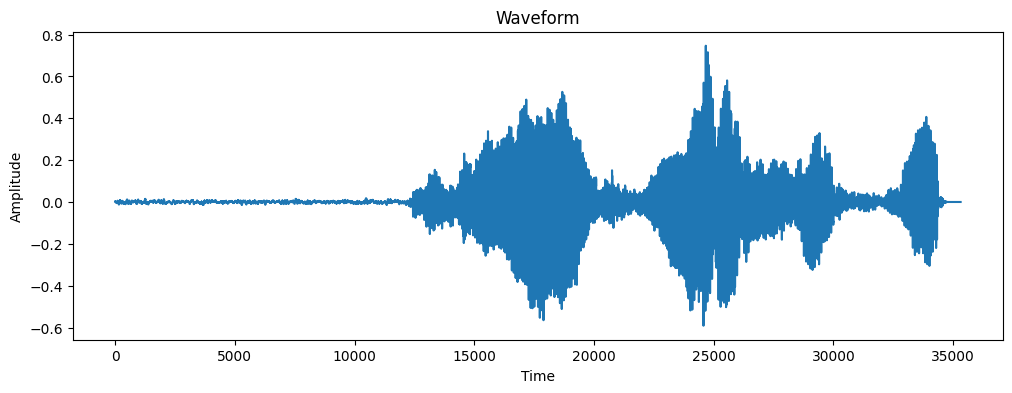

FEA


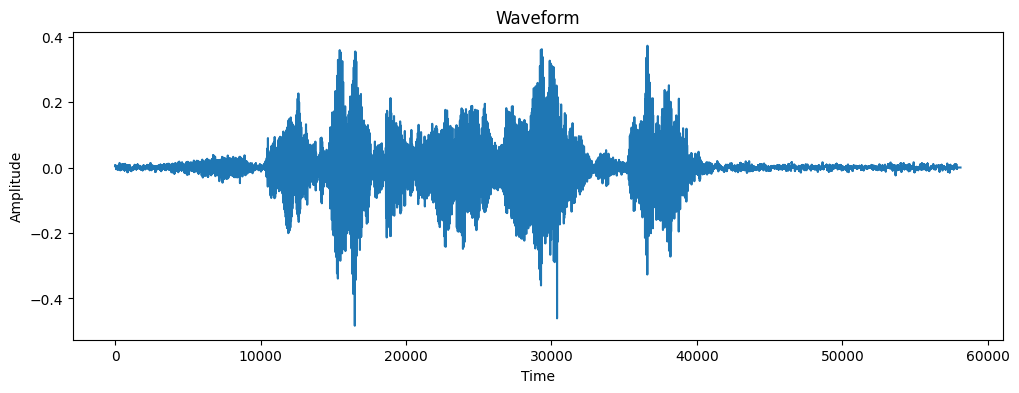

HAP


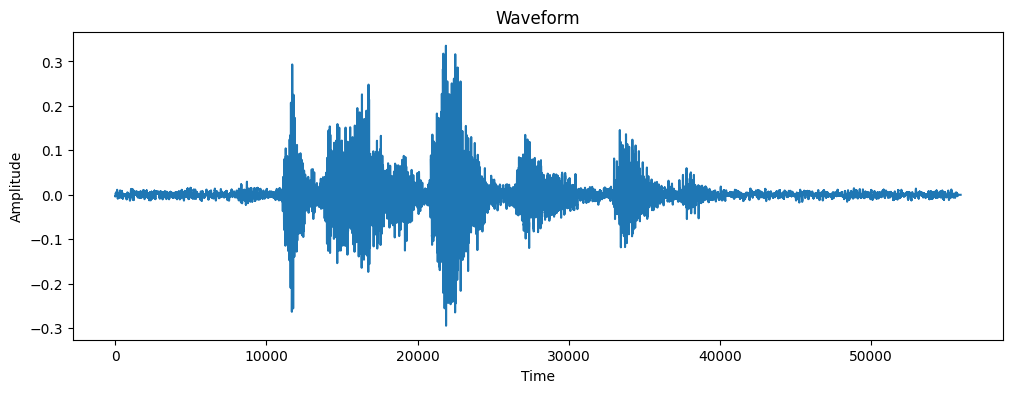

NEU


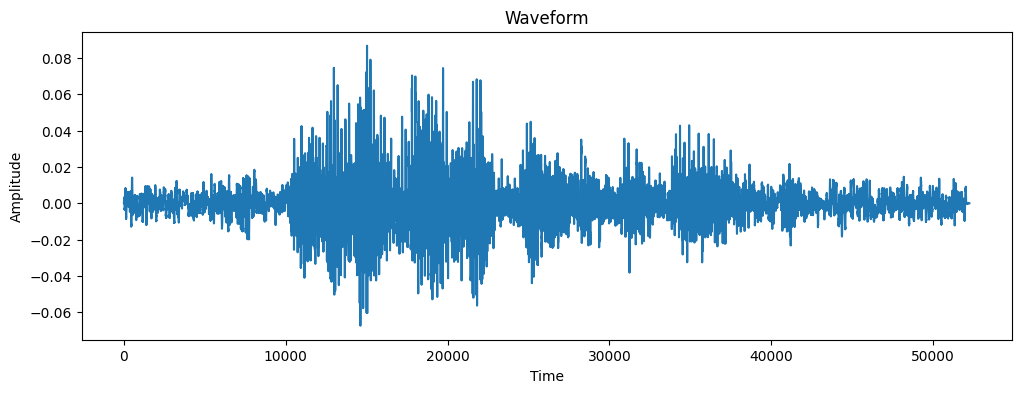

In [217]:
X_test_time,Y_test_time = loadAudioTime(D_test)
D_test_pca = pca.transform(X_test_time)

In [218]:
unicheck = np.unique(Y_test_time, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [219]:
df_freq = pd.DataFrame(Y_test_time)
df_freq.head()

0
0  FEA
1  SAD
2  HAP
3  DIS
4  FEA

In [220]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(2236, 6)


In [221]:
Y_time = one_hot_labels
Y_time.shape

(2236, 6)

70/70 [==============================] - 1s 4ms/step
Accuracy: 0.32021466905187834
F-score: 0.2670491461988128


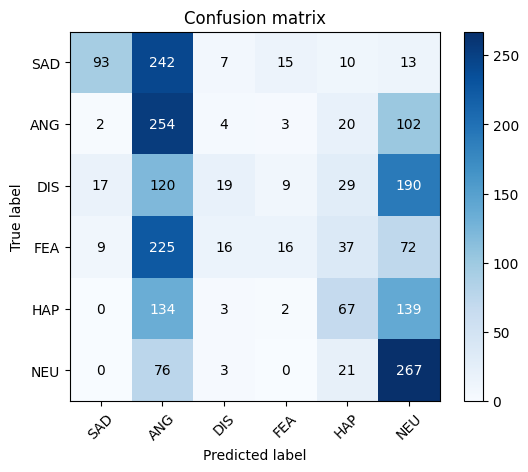

Most confusing classes: SAD and ANG


In [222]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(D_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_time, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"] 
# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
# Add numbers to the confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusing labels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', classes[most_confused_classes[0]], 'and', 
      classes[most_confused_classes[1]])

## Frequency Domain Model Without Augmentation

SAD


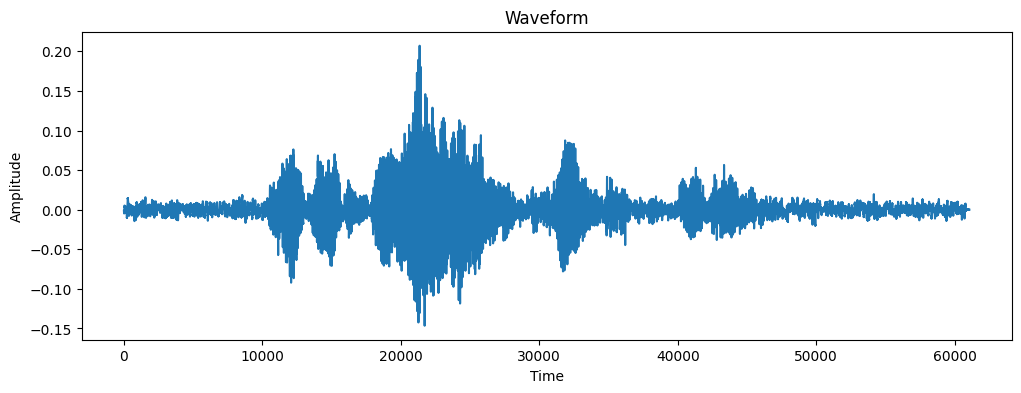

ANG


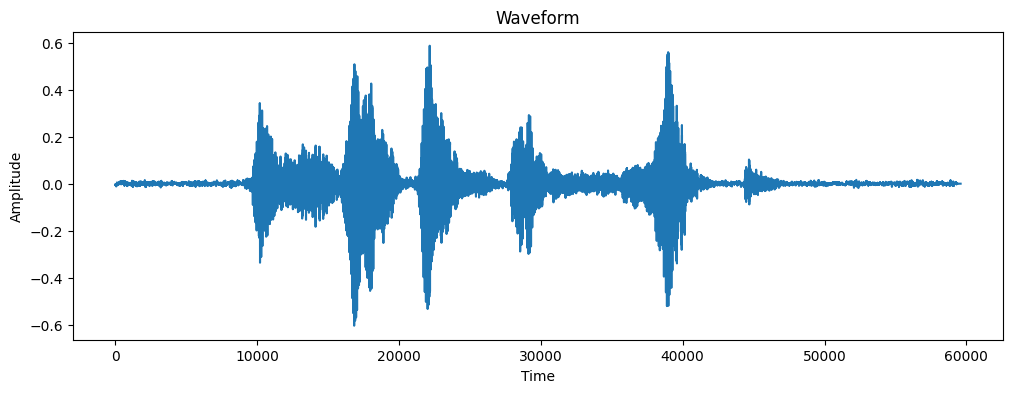

DIS


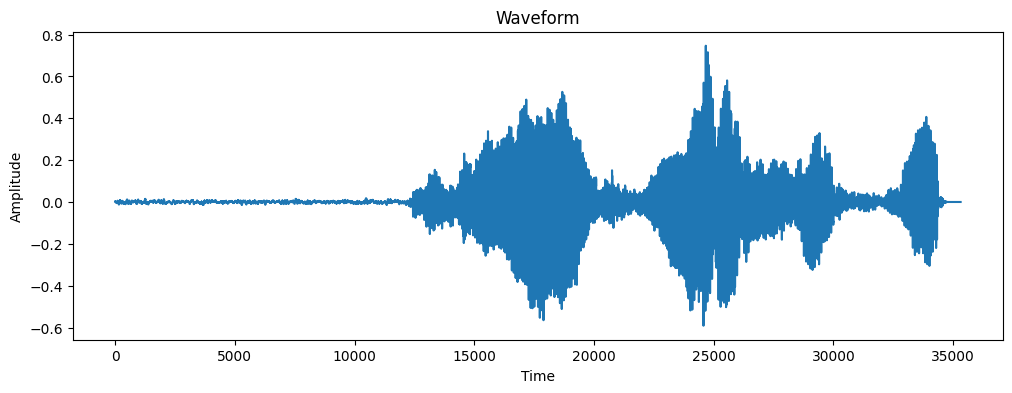

FEA


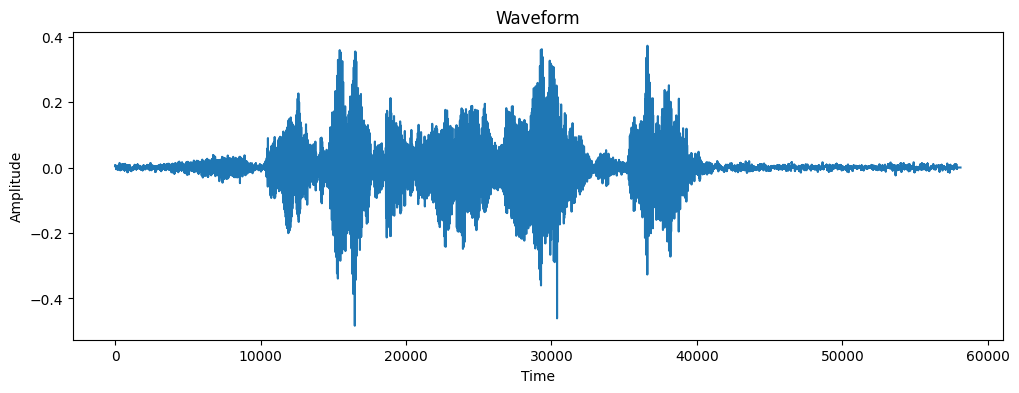

HAP


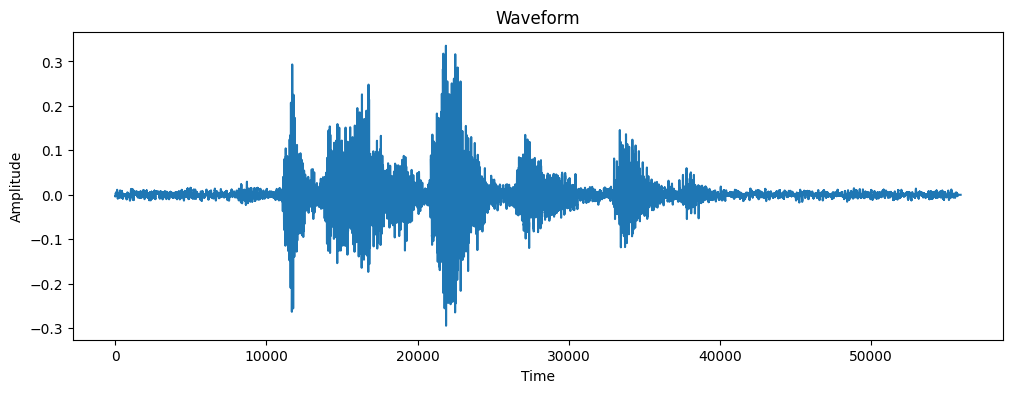

NEU


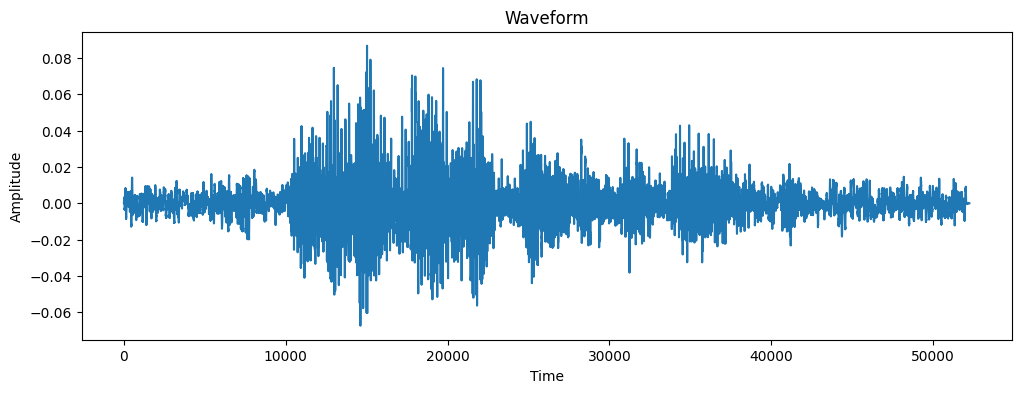

In [35]:
D_freq, Y_freq = loadAudioFreq(D_train)

In [36]:
unicheck = np.unique(Y_freq, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [37]:
df_freq = pd.DataFrame(Y_freq)
df_freq.head()

0
0  FEA
1  FEA
2  HAP
3  HAP
4  ANG

In [38]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(5216, 6)


In [39]:
Y_freq = one_hot_labels
Y_freq.shape

(5216, 6)

In [40]:
for i, array in enumerate(D_freq):
    D_freq[i] = np.pad(array, ((0, 0), (0, 256 - array.shape[1])))
D_freq = np.array(D_freq)

In [41]:
D_freq.shape

(5216, 64, 256)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(np.array(D_freq), np.array(Y_freq), test_size=0.05)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

((4955, 64, 256), (4955, 6), (261, 64, 256), (261, 6))


In [43]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
print(x_train.shape, x_test.shape)

(4955, 64, 256, 1) (261, 64, 256, 1)


In [44]:
model = Sequential()

# Layer 1: Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Flatten Layer
model.add(Flatten())

# Layer 5: Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Layer 6: Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Layer 7: Output Layer
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 254, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 127, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 125, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 30, 128)      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [45]:
# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

Epoch 1/50
39/39 [==============================] - 6s 92ms/step - loss: 1.9294 - accuracy: 0.2107 - val_loss: 1.7170 - val_accuracy: 0.3027
Epoch 2/50
39/39 [==============================] - 2s 50ms/step - loss: 1.6537 - accuracy: 0.3027 - val_loss: 1.5124 - val_accuracy: 0.3985
Epoch 3/50
39/39 [==============================] - 2s 49ms/step - loss: 1.6148 - accuracy: 0.3243 - val_loss: 1.4951 - val_accuracy: 0.4023
Epoch 4/50
39/39 [==============================] - 2s 49ms/step - loss: 1.5538 - accuracy: 0.3449 - val_loss: 1.4281 - val_accuracy: 0.4138
Epoch 5/50
39/39 [==============================] - 2s 49ms/step - loss: 1.5181 - accuracy: 0.3659 - val_loss: 1.4133 - val_accuracy: 0.3946
Epoch 6/50
39/39 [==============================] - 2s 48ms/step - loss: 1.5101 - accuracy: 0.3754 - val_loss: 1.4078 - val_accuracy: 0.4138
Epoch 7/50
39/39 [==============================] - 2s 54ms/step - loss: 1.4960 - accuracy: 0.3822 - val_loss: 1.3858 - val_accuracy: 0.4483
Epoch 8/50
39

SAD


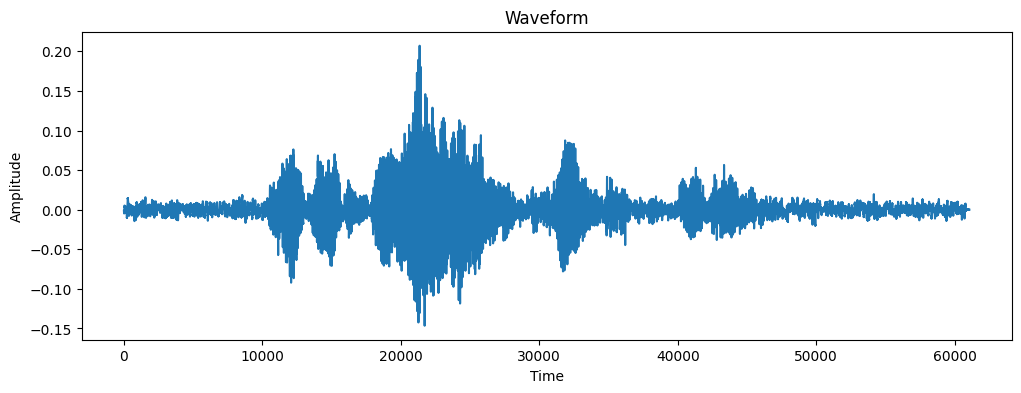

ANG


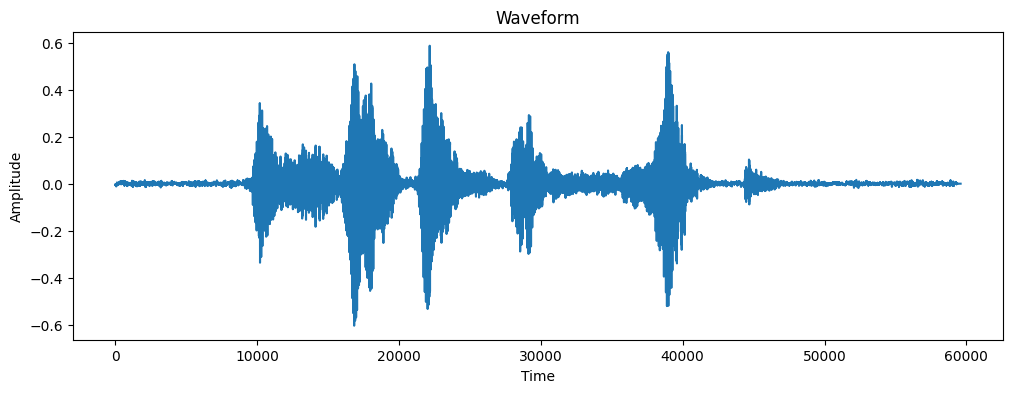

DIS


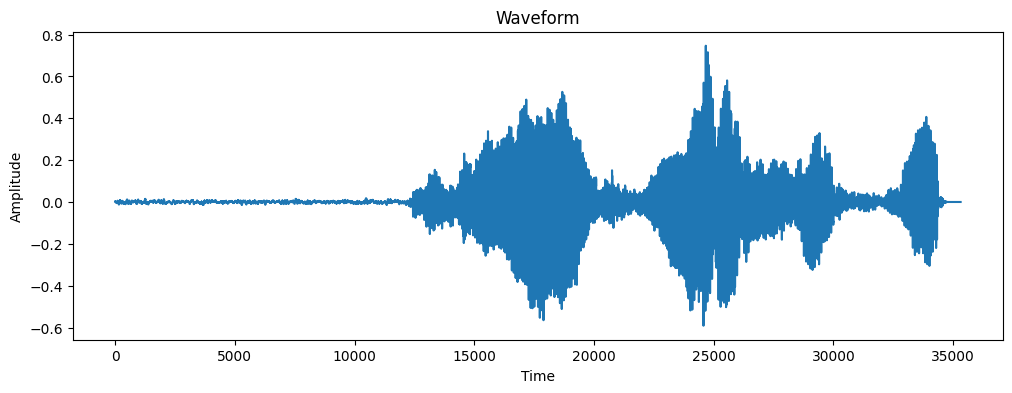

FEA


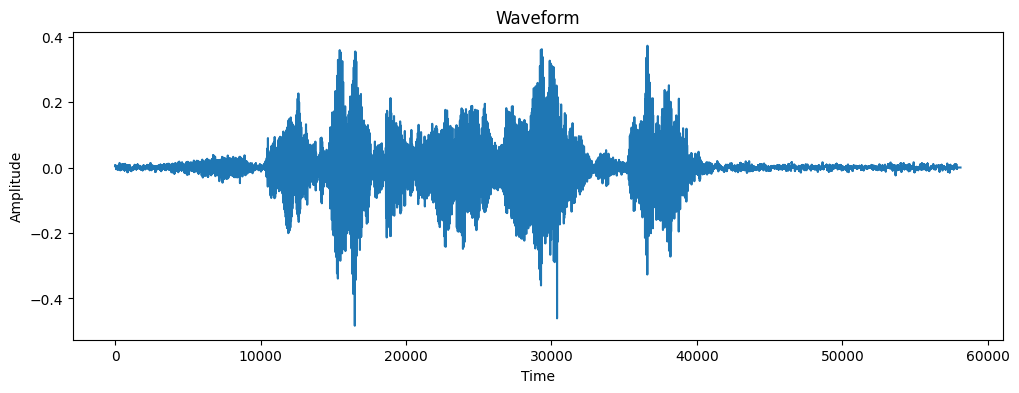

HAP


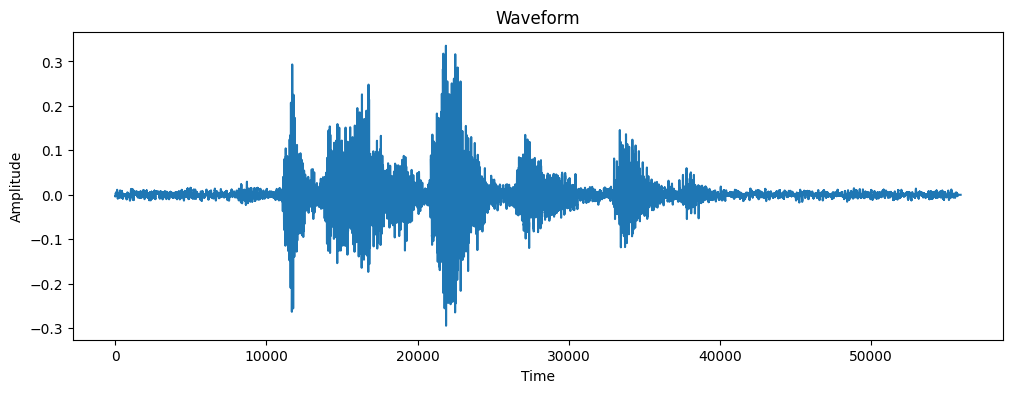

NEU


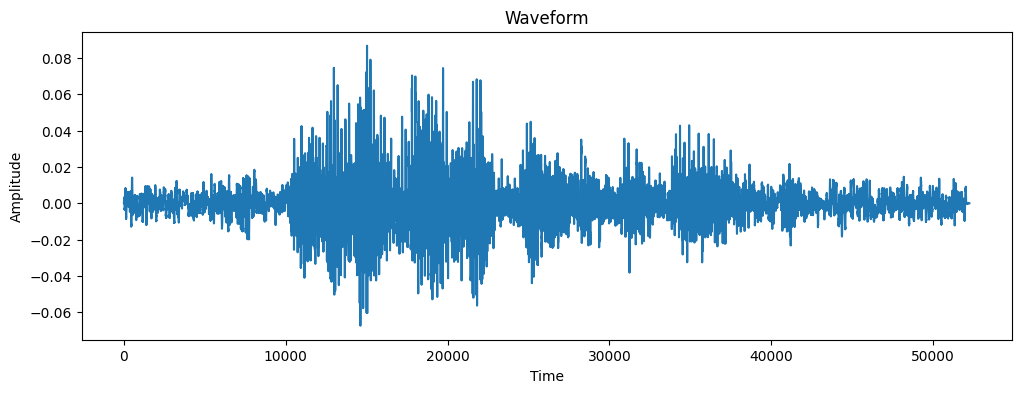

In [46]:
X_test_freq,Y_test_freq = loadAudioFreq(D_test)


In [47]:
unicheck = np.unique(Y_test_freq, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [48]:
df_freq = pd.DataFrame(Y_test_freq)
df_freq.head()

0
0  FEA
1  SAD
2  HAP
3  DIS
4  FEA

In [49]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(2236, 6)


In [50]:
Y_freq = one_hot_labels
Y_freq.shape

(2236, 6)

In [51]:
for i, array in enumerate(X_test_freq):
    X_test_freq[i] = np.pad(array, ((0, 0), (0, 256 - array.shape[1])))
X_test_freq = np.array(X_test_freq)
print( X_test_freq.shape)
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
#X_test_freq = x_test.reshape(( X_test_freq.shape[0],  X_test_freq.shape[1], X_test_freq.shape[2], 1))
print( X_test_freq.shape)

(2236, 64, 256)
(2236, 64, 256)


70/70 [==============================] - 1s 7ms/step
Accuracy: 0.4919499105545617
F-score: 0.48874311559263384


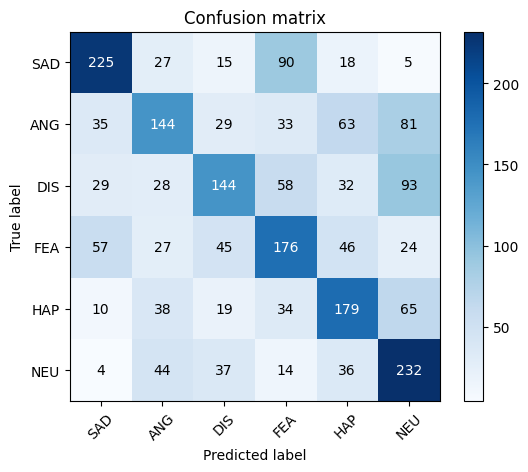

Most confusing classes: DIS and NEU


In [52]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
# Evaluate the model on the test set
y_pred = model.predict(X_test_freq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_freq, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"] 
# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
# Add numbers to the confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusing labels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', classes[most_confused_classes[0]], 'and', 
      classes[most_confused_classes[1]])

In [53]:
def loadAudioFreqA(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  # for data augmentation
  augmentations = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract mel spectrogram
    mel_spec = melSpectrogram(audio, sr)
    D.append(mel_spec)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    # don't augment every example
    if np.random.rand() >= 0.5:
      augmented_audio = augmentations(samples=audio, sample_rate=sr)
      mel_spec_aug = melSpectrogram(augmented_audio, sr)
      D.append(mel_spec_aug)
      for cls in classes:
        if re.search(cls, audio_file): Y.append(cls)
  return D, Y

## Time Domain Model With Augmentation

In [161]:
def loadAudioTimeA(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  # for data augmentation
  augmentations = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract zero crossing rate
    zcr = zeroCrossingRate(audio)
    # extract energy
    rms = energy(audio)
    # chroma stft
    cs = chromaStft(audio, sr)
    # mfcc
    mfc = mfcc(audio, sr)
    # extract mel spectrogram
    mel_spec = melSpectrogram(audio, sr).mean()
    combined_features = np.concatenate(([rms, cs, mfc, mel_spec], (np.pad(zcr[0], (0, 300 - len(zcr[0]))))))
    D.append(combined_features)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    # don't augment every example
    if np.random.rand() >= 0.5:
      augmented_audio = augmentations(samples=audio, sample_rate=sr)
      # extract zero crossing rate
      zcr = zeroCrossingRate(augmented_audio)
      # extract energy
      rms = energy(augmented_audio)
      # chroma stft
      cs = chromaStft(augmented_audio, sr)
      # mfcc
      mfc = mfcc(augmented_audio, sr)
      # extract mel spectrogram
      mel_spec = melSpectrogram(augmented_audio, sr).mean()
      combined_features = np.concatenate(([rms, cs, mfc, mel_spec], (np.pad(zcr[0], (0, 300 - len(zcr[0]))))))
      D.append(combined_features)
      for cls in classes:
        if re.search(cls, audio_file): Y.append(cls)
  return D, Y

In [162]:
D_time, Y_time = loadAudioTimeA(D_train)

/usr/local/lib/python3.10/dist-packages/librosa/util/decorators.py:88: UserWarning: Trying to estimate tuning from empty frequency set.
  return f(*args, **kwargs)


In [163]:
D_time = np.array(D_time)
D_time.shape

(7843, 304)

In [164]:
unicheck = np.unique(Y_time, axis=0)
print(f"Check on time domain:\n{unicheck}")

Check on time domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [165]:
df_time = pd.DataFrame(Y_time)
df_time.head()

0
0  FEA
1  FEA
2  FEA
3  HAP
4  HAP

In [166]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_time)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(7843, 6)


In [167]:
Y_time = one_hot_labels
Y_time.shape

(7843, 6)

In [168]:
# Apply PCA to the data
pca = PCA(n_components=200)
D_pca = pca.fit_transform(D_time)

In [169]:
# Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(np.array(D_pca), np.array(Y_time), test_size=0.05, random_state=69, shuffle=True, stratify=Y_time)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

model = Sequential()
model.add(Conv1D(128, 3, input_shape=(x_train.shape[1], 1), kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(256, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(512, 3, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(1024, 3,  kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())
model.add(Dense(512, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

model.add(Dense(256, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(128, kernel_regularizer=regularizers.l2(0.001)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.2))

model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

model.summary()

# Train the model with early stopping
history = model.fit(x_train, y_train,
                    validation_data=(x_train, y_train),
                    epochs=50,
                    batch_size=32,
                    callbacks=callbacks)

((7450, 200), (7450, 6), (393, 200), (393, 6))
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_8 (Conv1D)           (None, 198, 128)          512       
                                                                 
 batch_normalization_14 (Bat  (None, 198, 128)         512       
 chNormalization)                                                
                                                                 
 activation_14 (Activation)  (None, 198, 128)          0         
                                                                 
 max_pooling1d_8 (MaxPooling  (None, 99, 128)          0         
 1D)                                                             
                                                                 
 conv1d_9 (Conv1D)           (None, 97, 256)           98560     
                                                                 
 batch_

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/50
233/233 [==============================] - 8s 26ms/step - loss: 3.2219 - accuracy: 0.2934 - val_loss: 3.0850 - val_accuracy: 0.1732
Epoch 2/50
233/233 [==============================] - 4s 19ms/step - loss: 2.6234 - accuracy: 0.3264 - val_loss: 2.6851 - val_accuracy: 0.2093
Epoch 3/50
233/233 [==============================] - 4s 19ms/step - loss: 2.4115 - accuracy: 0.3552 - val_loss: 2.3825 - val_accuracy: 0.3180
Epoch 4/50
233/233 [==============================] - 5s 21ms/step - loss: 2.3014 - accuracy: 0.3604 - val_loss: 2.2636 - val_accuracy: 0.3370
Epoch 5/50
233/233 [==============================] - 5s 23ms/step - loss: 2.1870 - accuracy: 0.3646 - val_loss: 2.1574 - val_accuracy: 0.3772
Epoch 6/50
233/233 [==============================] - 4s 18ms/step - loss: 2.1027 - accuracy: 0.3811 - val_loss: 2.0575 - val_accuracy: 0.3746
Epoch 7/50
233/233 [==============================] - 5s 22ms/step - loss: 2.0208 - accuracy: 0.3867 - val_loss: 2.1400 - val_accuracy: 0.3150

In [170]:
X_test_time,Y_test_time = loadAudioTimeA(D_test)
D_test_pca = pca.transform(X_test_time)

In [171]:
unicheck = np.unique(Y_test_time, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [172]:
df_freq = pd.DataFrame(Y_test_time)
df_freq.head()

0
0  FEA
1  SAD
2  SAD
3  HAP
4  DIS

In [173]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(3342, 6)


In [174]:
Y_time = one_hot_labels
Y_time.shape

(3342, 6)

105/105 [==============================] - 1s 6ms/step
Accuracy: 0.37283064033512864
F-score: 0.3606211552605909


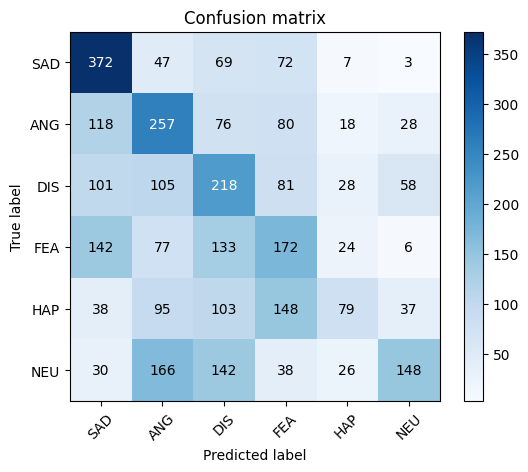

Most confusing classes: NEU and ANG


In [175]:
classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"] 
y_pred = model.predict(D_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_time, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
# Add numbers to the confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusing labels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', classes[most_confused_classes[0]], 'and', 
      classes[most_confused_classes[1]])

## Frequency Domain Model With Augmentation

In [190]:
def loadAudioFreqA(audio_files):
  classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"]
  # for data augmentation
  augmentations = Compose([
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.01, p=0.5),
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-4, max_semitones=4, p=0.5)
])
  # max_length = getMaxLen(audio_files)
  max_length = 200
  D, Y = [], []
  for audio_file in audio_files: 
    # load the audio file
    audio, sr = lib.load(audio_file, sr=4444)
    # extract mel spectrogram
    mel_spec = melSpectrogram(audio, sr)
    D.append(mel_spec)
    for cls in classes:
      if re.search(cls, audio_file): Y.append(cls)
    # don't augment every example
    if np.random.rand() >= 0.5:
      augmented_audio = augmentations(samples=audio, sample_rate=sr)
      mel_spec_aug = melSpectrogram(augmented_audio, sr)
      D.append(mel_spec_aug)
      for cls in classes:
        if re.search(cls, audio_file): Y.append(cls)
  return D, Y

In [191]:
D_freq, Y_freq = loadAudioFreqA(D_train)

In [192]:
unicheck = np.unique(Y_freq, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [193]:
df_freq = pd.DataFrame(Y_freq)
df_freq.head()

0
0  FEA
1  FEA
2  FEA
3  HAP
4  HAP

In [194]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(7845, 6)


In [195]:
Y_freq = one_hot_labels
Y_freq.shape

(7845, 6)

In [196]:
for i, array in enumerate(D_freq):
    D_freq[i] = np.pad(array, ((0, 0), (0, 256 - array.shape[1])))
D_freq = np.array(D_freq)

In [197]:
D_freq.shape

(7845, 64, 256)

In [198]:
x_train, x_test, y_train, y_test = train_test_split(np.array(D_freq), np.array(Y_freq), test_size=0.05)
print((x_train.shape, y_train.shape, x_test.shape, y_test.shape))

((7452, 64, 256), (7452, 6), (393, 64, 256), (393, 6))


In [199]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
print(x_train.shape, x_test.shape)

(7452, 64, 256, 1) (393, 64, 256, 1)


In [200]:
model = Sequential()

# Layer 1: Convolutional Layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2: Convolutional Layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 3: Convolutional Layer
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 4: Flatten Layer
model.add(Flatten())

# Layer 5: Fully Connected Layer
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

# Layer 6: Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Layer 7: Output Layer
model.add(Dense(6, activation='sigmoid'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(lr=0.0005),
             metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_25 (Conv2D)          (None, 62, 254, 32)       320       
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 31, 127, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 29, 125, 64)       18496     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 14, 62, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_27 (Conv2D)          (None, 12, 60, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 6, 30, 128)      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [201]:
# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

history = model.fit(x_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

Epoch 1/50
59/59 [==============================] - 4s 64ms/step - loss: 1.9603 - accuracy: 0.1950 - val_loss: 1.7154 - val_accuracy: 0.3359
Epoch 2/50
59/59 [==============================] - 3s 53ms/step - loss: 1.6536 - accuracy: 0.3030 - val_loss: 1.5661 - val_accuracy: 0.3919
Epoch 3/50
59/59 [==============================] - 3s 49ms/step - loss: 1.5793 - accuracy: 0.3470 - val_loss: 1.4858 - val_accuracy: 0.3740
Epoch 4/50
59/59 [==============================] - 3s 49ms/step - loss: 1.5507 - accuracy: 0.3599 - val_loss: 1.4774 - val_accuracy: 0.4249
Epoch 5/50
59/59 [==============================] - 3s 49ms/step - loss: 1.5207 - accuracy: 0.3745 - val_loss: 1.4350 - val_accuracy: 0.4453
Epoch 6/50
59/59 [==============================] - 3s 52ms/step - loss: 1.5094 - accuracy: 0.3791 - val_loss: 1.4448 - val_accuracy: 0.4122
Epoch 7/50
59/59 [==============================] - 3s 51ms/step - loss: 1.4914 - accuracy: 0.3904 - val_loss: 1.4160 - val_accuracy: 0.4555
Epoch 8/50
59

In [202]:
X_test_freq,Y_test_freq = loadAudioFreqA(D_test)


In [203]:
unicheck = np.unique(Y_test_freq, axis=0)
print(f"Check on freq domain:\n{unicheck}")

Check on freq domain:
['ANG' 'DIS' 'FEA' 'HAP' 'NEU' 'SAD']


In [204]:
df_freq = pd.DataFrame(Y_test_freq)
df_freq.head()

0
0  FEA
1  FEA
2  SAD
3  HAP
4  HAP

In [205]:
# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)

(3339, 6)


In [206]:
Y_freq = one_hot_labels
Y_freq.shape

(3339, 6)

In [207]:
for i, array in enumerate(X_test_freq):
    X_test_freq[i] = np.pad(array, ((0, 0), (0, 256 - array.shape[1])))
X_test_freq = np.array(X_test_freq)
print( X_test_freq.shape)
#x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
#X_test_freq = x_test.reshape(( X_test_freq.shape[0],  X_test_freq.shape[1], X_test_freq.shape[2], 1))
print( X_test_freq.shape)

(3339, 64, 256)
(3339, 64, 256)


105/105 [==============================] - 1s 6ms/step
Accuracy: 0.48846960167714887
F-score: 0.48551073527436106


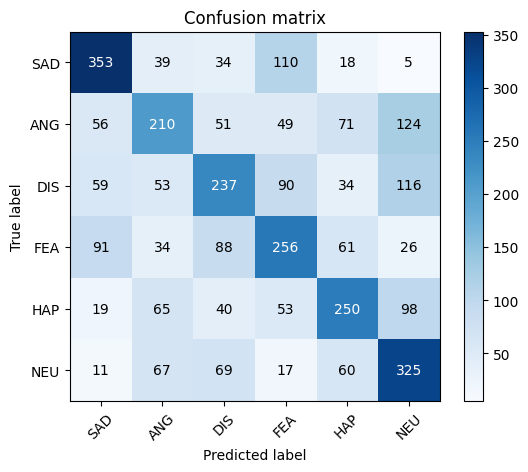

Most confusing classes: ANG and NEU


In [208]:
classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"] 
y_pred = model.predict(X_test_freq)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_freq, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
# Add numbers to the confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusing labels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', classes[most_confused_classes[0]], 'and', 
      classes[most_confused_classes[1]])

### VGG model implementation

SAD


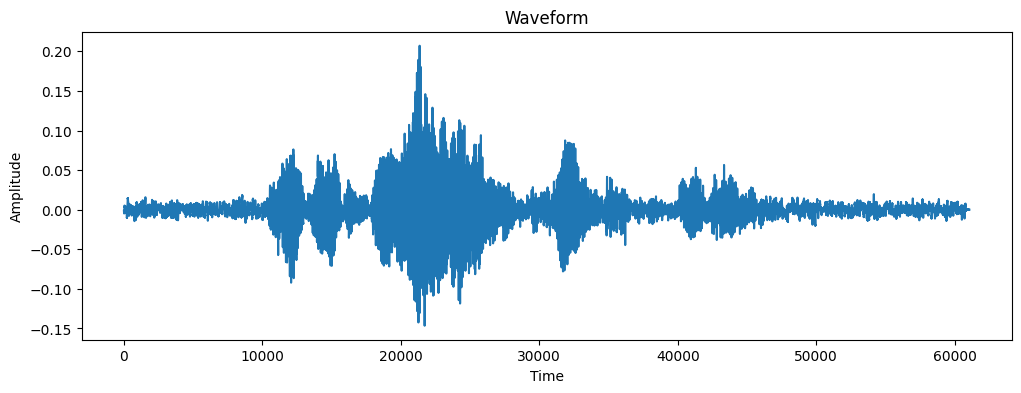

ANG


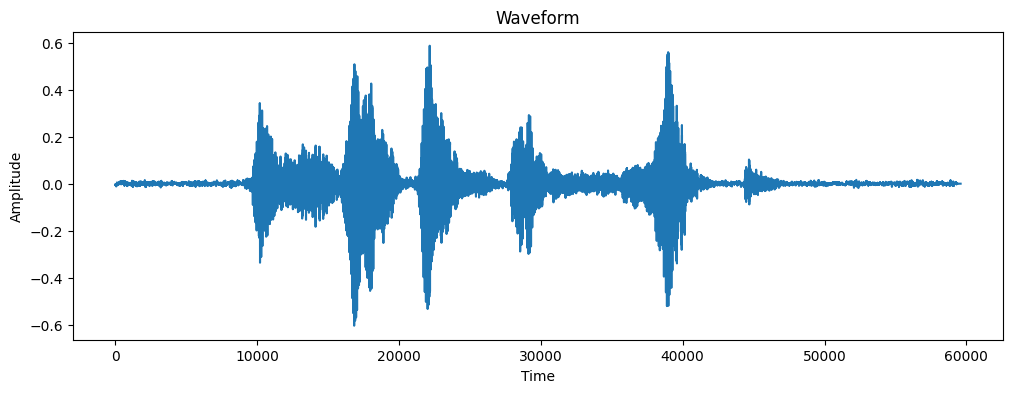

DIS


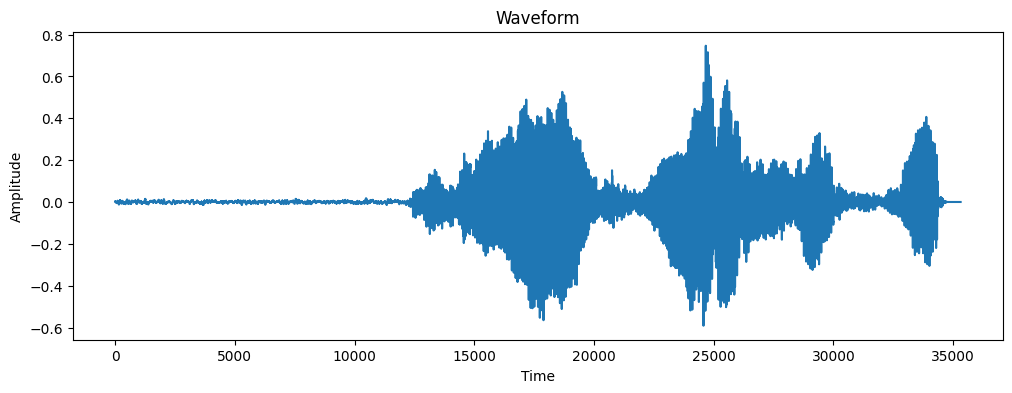

FEA


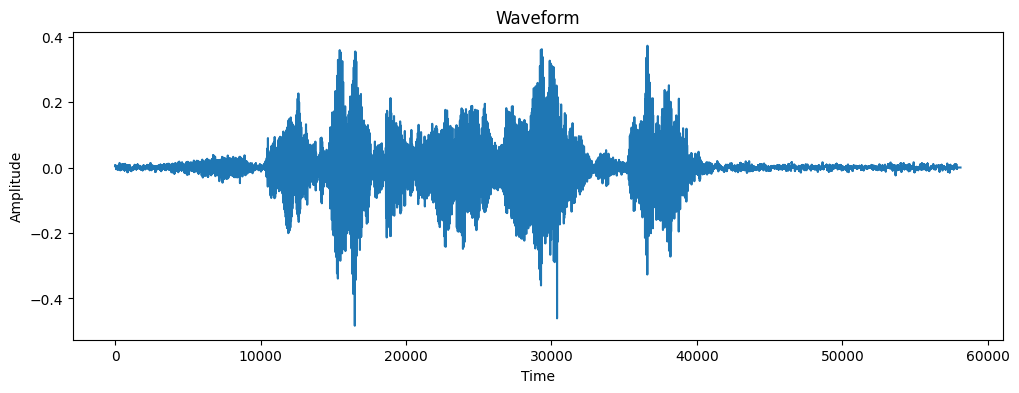

HAP


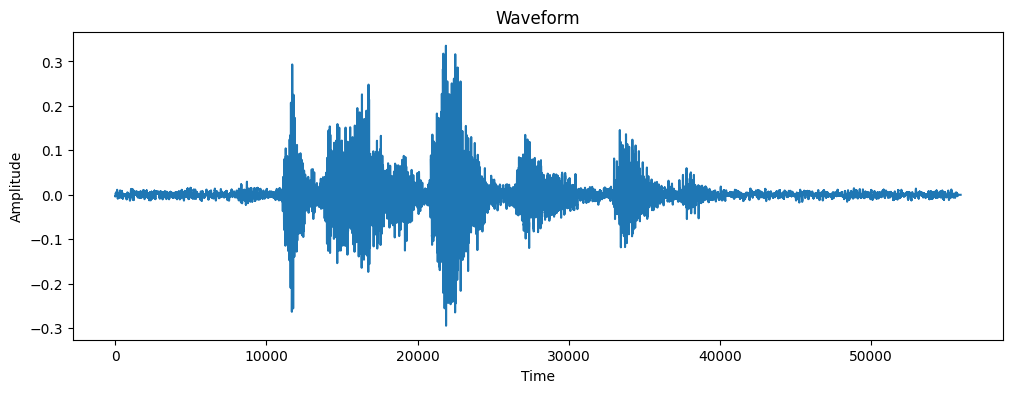

NEU


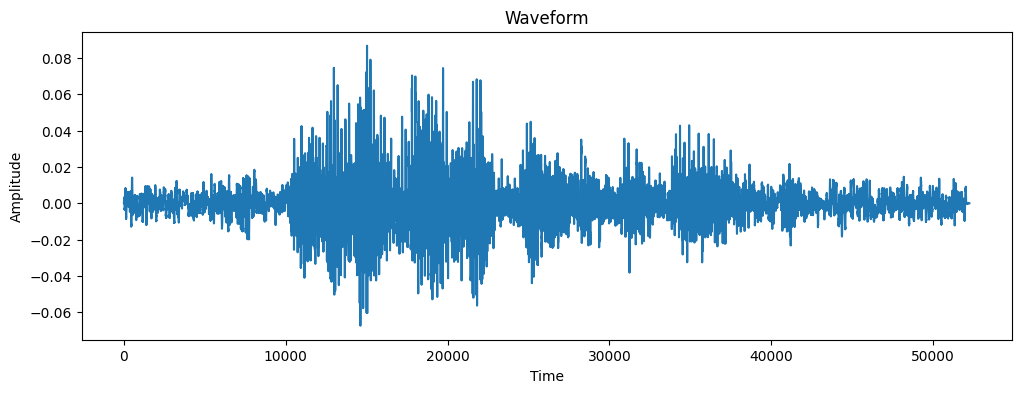

In [88]:
D_freq, Y_freq = loadAudioFreq(D_train)

In [89]:
D_freq[0].shape[1]

23

In [90]:
# perform padding to make input as same shape as that used in VGG
D_freq2 = []
for i, array in enumerate(D_freq):
  D_freq2.append(np.pad(array, ((0, 224 - array.shape[0]), (0, 224 - array.shape[1]))))
D_freq2 = np.array(D_freq2)

In [91]:
D_freq2[0].shape

(224, 224)

In [92]:
df_freq = pd.DataFrame(Y_freq)

# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)
Y_freq = one_hot_labels
Y_freq.shape

(5216, 6)


(5216, 6)

In [93]:
x_train, x_test, y_train, y_test = train_test_split(np.array(D_freq2), np.array(Y_freq), test_size=0.05)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(4955, 224, 224) (4955, 6) (261, 224, 224) (261, 6)


In [94]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], x_test.shape[2], 1))
print(x_train.shape, x_test.shape)

(4955, 224, 224, 1) (261, 224, 224, 1)


In [95]:
weight_decay = 0.0005
model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1), 
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
          kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Fully connected layers
model.add(Flatten())
model.add(Dense(4096, activation='relu', kernel_regularizer=l2(weight_decay)))
# Dropout regularization with a dropout ratio of 0.5
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(Dropout(0.5))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.SGD(lr=0.0005, momentum=0.9),
             metrics=['accuracy'])

# Print the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 224, 224, 64)      640       
                                                                 
 conv2d_7 (Conv2D)           (None, 224, 224, 64)      36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 112, 112, 128)     73856     
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 128)     147584    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 128)      0         
 2D)                                                  

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [96]:
# Specify thecallbacks for the model
callbacks = [EarlyStopping(monitor='val_loss', patience=10)]

history = model.fit(x_train, y_train,
                    epochs=74,
                    # original model is 256, we use 64 to avoid memory error
                    batch_size=64,
                    validation_data=(x_test, y_test),
                    callbacks=callbacks)

Epoch 1/74
78/78 [==============================] - 98s 957ms/step - loss: 9.2898 - accuracy: 0.1643 - val_loss: 9.2841 - val_accuracy: 0.1992
Epoch 2/74
78/78 [==============================] - 63s 803ms/step - loss: 9.2807 - accuracy: 0.1826 - val_loss: 9.2770 - val_accuracy: 0.1877
Epoch 3/74
78/78 [==============================] - 62s 798ms/step - loss: 9.2723 - accuracy: 0.1865 - val_loss: 9.2678 - val_accuracy: 0.2069
Epoch 4/74
78/78 [==============================] - 62s 800ms/step - loss: 9.2640 - accuracy: 0.2079 - val_loss: 9.2572 - val_accuracy: 0.2031
Epoch 5/74
78/78 [==============================] - 63s 806ms/step - loss: 9.2554 - accuracy: 0.2036 - val_loss: 9.2447 - val_accuracy: 0.2299
Epoch 6/74
78/78 [==============================] - 63s 808ms/step - loss: 9.2435 - accuracy: 0.2101 - val_loss: 9.2311 - val_accuracy: 0.2222
Epoch 7/74
78/78 [==============================] - 63s 803ms/step - loss: 9.2314 - accuracy: 0.2228 - val_loss: 9.2166 - val_accuracy: 0.2452

SAD


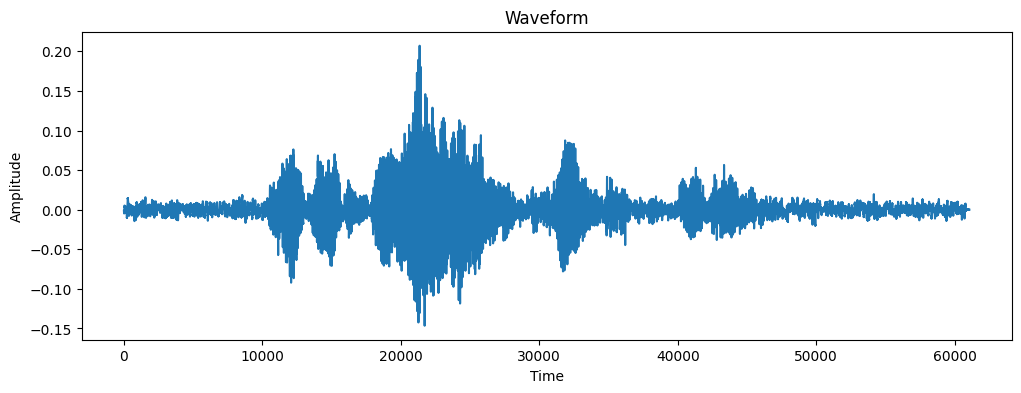

ANG


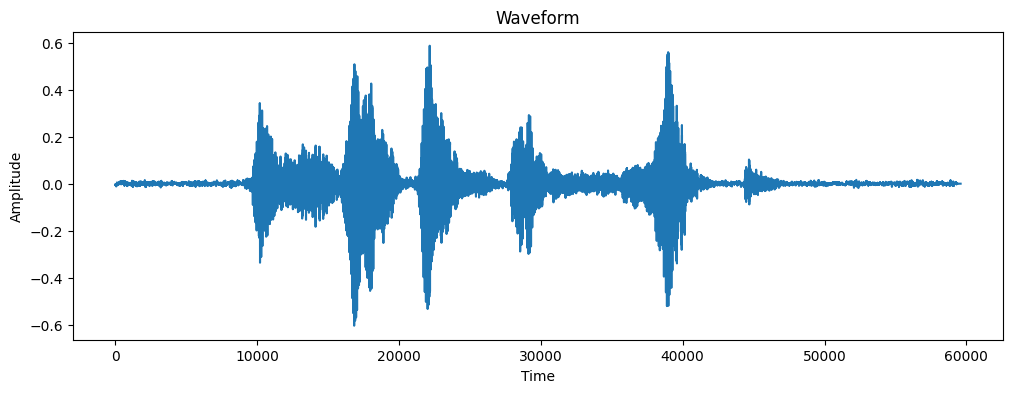

DIS


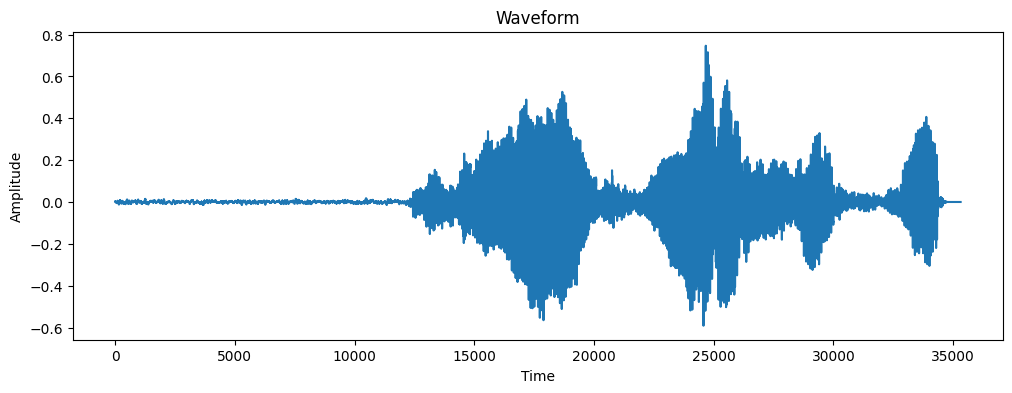

FEA


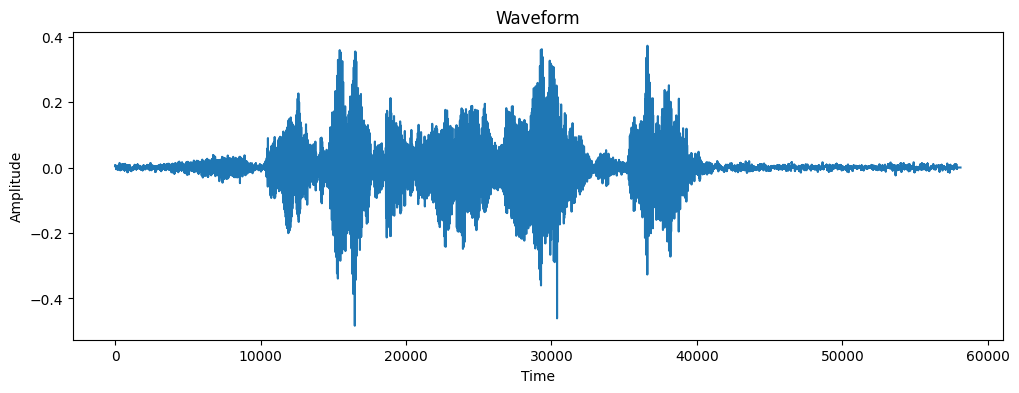

HAP


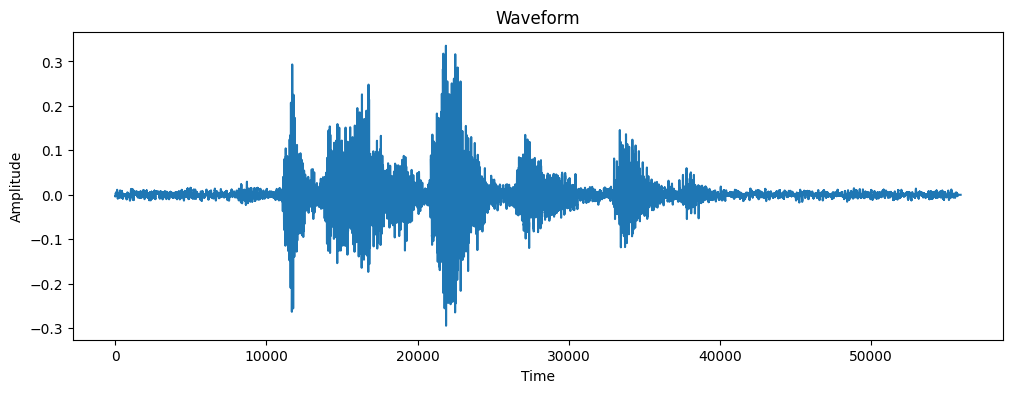

NEU


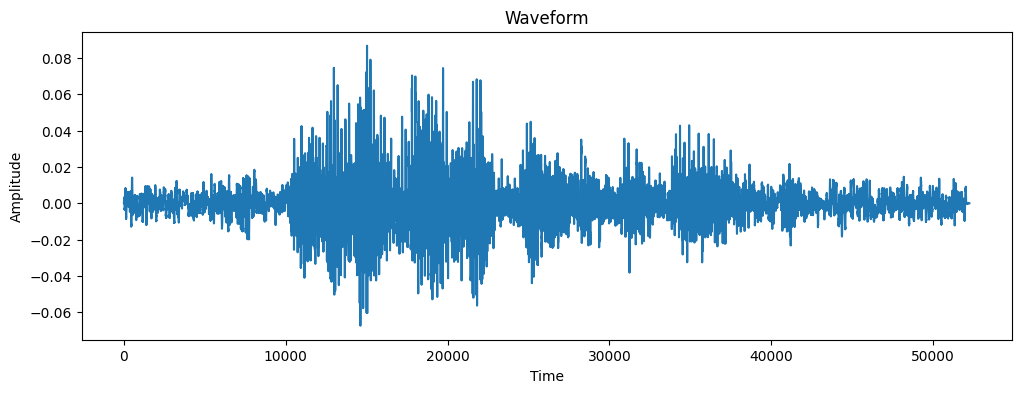

In [116]:
X_test_freq,Y_test_freq = loadAudioFreq(D_test)


In [117]:
D_freq[0].shape[1]

23

In [118]:
# perform padding to make input as same shape as that used in VGG
D_freq2 = []
for i, array in enumerate(X_test_freq):
  D_freq2.append(np.pad(array, ((0, 224 - array.shape[0]), (0, 224 - array.shape[1]))))
D_freq2 = np.array(D_freq2)

In [119]:
D_freq2[0].shape

(224, 224)

In [120]:
df_freq = pd.DataFrame(Y_test_freq)

# Use the get_dummies() method to one-hot encode the labels
one_hot_labels = pd.get_dummies(df_freq)

# Convert the DataFrame to a NumPy array
one_hot_labels = one_hot_labels.to_numpy()

print(one_hot_labels.shape)
Y_freq = one_hot_labels
Y_freq.shape

(2236, 6)


(2236, 6)

70/70 [==============================] - 8s 112ms/step
Accuracy: 0.4803220035778175
F-score: 0.46910926381211665


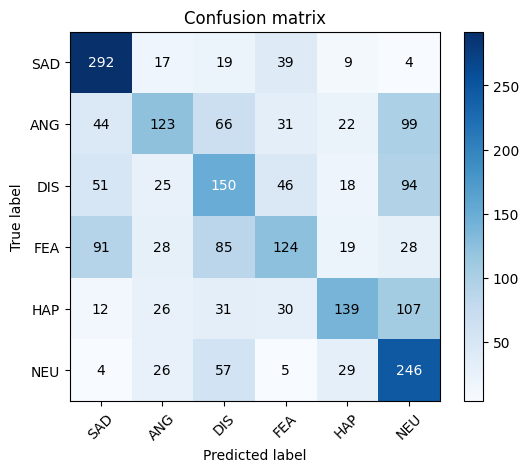

Most confusing classes: HAP and NEU


In [121]:
classes = ["SAD", "ANG", "DIS", "FEA", "HAP", "NEU"] 
y_pred = model.predict(D_freq2)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(Y_freq, axis=1)
accuracy = accuracy_score(y_test_classes, y_pred_classes)
f_score = f1_score(y_test_classes, y_pred_classes, average='weighted')
print('Accuracy:', accuracy)
print('F-score:', f_score)

# Plot the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.imshow(cm, cmap=plt.cm.Blues)
plt.title('Confusion matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
# Add numbers to the confusion matrix
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max()/2 else 'black')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Find the most confusing labels
np.fill_diagonal(cm, 0)
most_confused_classes = np.unravel_index(np.argmax(cm), cm.shape)
print('Most confusing classes:', classes[most_confused_classes[0]], 'and', 
      classes[most_confused_classes[1]])